In [1]:
# Model Configuration
# TensorFlow
# Plotting
# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
# Data
from tensorflow.io import FixedLenFeature
AUTO = tf.data.experimental.AUTOTUNE

print("Tensorflow version " + tf.__version__)
UNITS = 2 ** 11 # 2048
ACTIVATION = 'relu'
DROPOUT = 0.1

# Training Configuration
BATCH_SIZE_PER_REPLICA = 2 ** 11 # powers of 128 are best

# Matplotlib defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)

# The dataset has been encoded in a binary file format called TFRecords.
# These two functions will parse the TFRecords and
# build a TensorFlow tf.data.Dataset object that we can use for training.

def make_decoder(feature_description):
    def decoder(example):
        example = tf.io.parse_single_example(example, feature_description)
        features = tf.io.parse_tensor(example['features'], tf.float32)
        features = tf.reshape(features, [28])
        label = example['label']
        # Return wide and deep inputs as a tuple
        return {'wide': features, 'deep': features}, label
    return decoder

def load_dataset(filenames, decoder, ordered=False):
    AUTO = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = (
        tf.data
        .TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(ignore_order)
        .map(decoder, AUTO)
    )
    return dataset
dataset_size = int(11e6)
validation_size = int(5e5)
training_size = dataset_size - validation_size

# For model.fit
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = training_size // batch_size
validation_steps = validation_size // batch_size

# For model.compile
steps_per_execution = 256    

feature_description = {
    'features': FixedLenFeature([], tf.string),
    'label': FixedLenFeature([], tf.float32),
}
decoder = make_decoder(feature_description)

data_dir = 'Downloads/Higgs Boson'
train_files = tf.io.gfile.glob(data_dir + '/training' + '/*.tfrecord')
valid_files = tf.io.gfile.glob(data_dir + '/validation' + '/*.tfrecord')

ds_train = load_dataset(train_files, decoder, ordered=False)
ds_train = (
    ds_train
    .cache()
    .repeat()
    .shuffle(2 ** 19)
    .batch(batch_size)
    .prefetch(AUTO)
)

ds_valid = load_dataset(valid_files, decoder, ordered=False)
ds_valid = (
    ds_valid
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

wide_input_shape = 28

from tensorflow.keras import layers, models, optimizers, losses

def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    def make(inputs):
        x = layers.Dense(units, kernel_regularizer=keras.regularizers.l2(l2))(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    return make

with strategy.scope():
    # Wide Network
    wide = layers.Input(shape=(wide_input_shape,), name='wide')
    wide_output = layers.Dense(1, activation='sigmoid')(wide)
    wide_model = models.Model(inputs=wide, outputs=wide_output)

    # Deep Network
    inputs = layers.Input(shape=[28], name='deep')
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(inputs)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    deep_model = models.Model(inputs=inputs, outputs=outputs)
    
    # Combine Wide and Deep Networks
    wide_and_deep_inputs = [wide, inputs]
    wide_and_deep_outputs = [wide_output, outputs]
    wide_and_deep = models.Model(inputs=wide_and_deep_inputs, outputs=wide_and_deep_outputs)

wide_and_deep.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['AUC', 'binary_accuracy'],
)

# During training, we'll use the EarlyStopping callback as usual.
# Notice that we've also defined a learning rate schedule.
# It's been found that gradually decreasing the learning rate over the course of training can improve performance (the weights "settle in" to a minimum).
# This schedule will multiply the learning rate by 0.2 if the validation loss didn't decrease after an epoch.
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)



Tensorflow version 2.10.1
Number of accelerators:  1


In [2]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


In [3]:
history = wide_and_deep.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_schedule],
)


Epoch 1/50
5126/5126 [==============================] - 258s 49ms/step - loss: 1.6119 - dense_loss: 0.6627 - dense_6_loss: 0.5693 - dense_auc: 0.6387 - dense_binary_accuracy: 0.6056 - dense_6_auc_1: 0.7747 - dense_6_binary_accuracy: 0.7043 - val_loss: 1.2625 - val_dense_loss: 0.6425 - val_dense_6_loss: 0.5812 - val_dense_auc: 0.6707 - val_dense_binary_accuracy: 0.6279 - val_dense_6_auc_1: 0.7873 - val_dense_6_binary_accuracy: 0.6949 - lr: 0.0010
Epoch 2/50
5126/5126 [==============================] - 255s 50ms/step - loss: 1.2170 - dense_loss: 0.6400 - dense_6_loss: 0.5412 - dense_auc: 0.6765 - dense_binary_accuracy: 0.6328 - dense_6_auc_1: 0.7988 - dense_6_binary_accuracy: 0.7225 - val_loss: 1.2000 - val_dense_loss: 0.6388 - val_dense_6_loss: 0.5343 - val_dense_auc: 0.6788 - val_dense_binary_accuracy: 0.6350 - val_dense_6_auc_1: 0.8060 - val_dense_6_binary_accuracy: 0.7281 - lr: 0.0010
Epoch 3/50
5126/5126 [==============================] - 271s 53ms/step - loss: 1.2014 - dense_loss: 

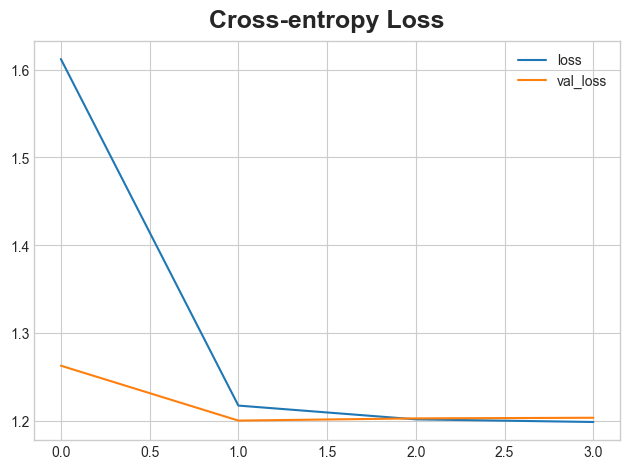

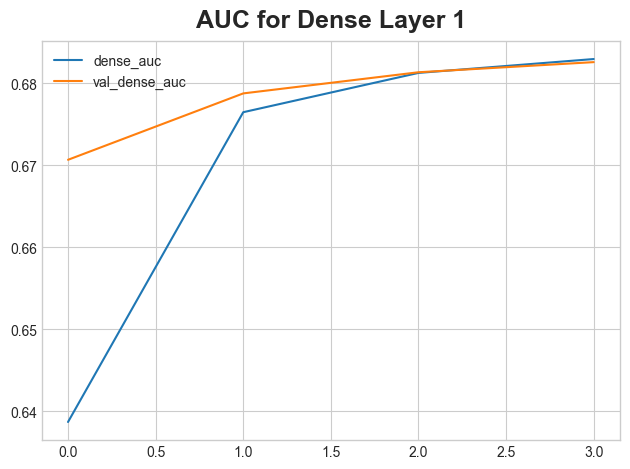

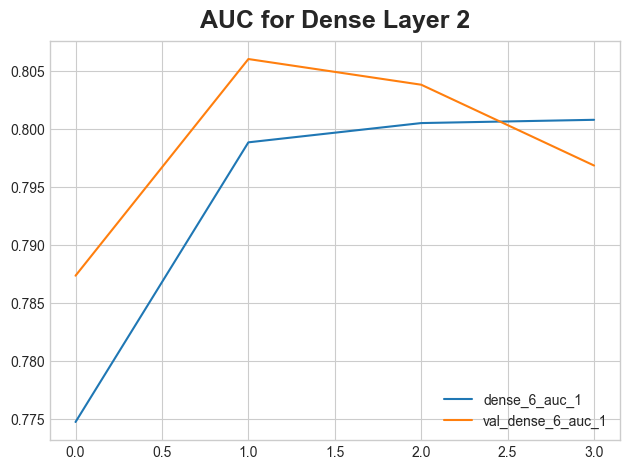

In [7]:
# Plotting the AUC for the first output
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot(title='Cross-entropy Loss')
plt.show()
# Training and validation AUC for the first output
history_frame.loc[:, ['dense_auc', 'val_dense_auc']].plot(title='AUC for Dense Layer 1')
plt.show()

# Training and validation AUC for the second output
history_frame.loc[:, ['dense_6_auc_1', 'val_dense_6_auc_1']].plot(title='AUC for Dense Layer 2')
plt.show()